# JanataHack - HR Analytics

Author: Joanna Khek Cuina   
Date: 9 May 2020

# Project Description

A training institute which conducts training for analytics/ data science wants to expand their business to manpower recruitment (data science only) as well.    
 
Company gets large number of signups for their trainings. Now, company wants to connect these enrollees with their clients who are looking to hire employees working in the same domain. Before that, it is important to know which of these candidates are really looking for a new employment. They have student information related to demographics, education, experience and features related to training as well.   
 
To understand the factors that lead a person to look for a job change, the agency wants you to design a model that uses the current credentials/demographics/experience to predict the probability of an enrollee to look for a new job.   

# Data Dictionary

- enrollee_id: Unique ID for enrollee    
- city: City code     
- city_development_index: Developement index of the city (scaled)     
- gender: Gender      
- relevent_experience: Relevent experience   
- enrolled_university: Type of University course enrolled if any    
- education_level: Education level    
- major_discipline: Major discipline    
- experience: Total experience in years    
- company_size: No of employees in current employer's company     
- company_type: Type of current employer     
- last_new_job: Difference in years between previous job and current job   
- training_hours: training hours completed    
- target: 0 – Not looking for job change, 1 – Looking for a job change   

# 1. Import Libraries

In [298]:
import pandas as pd
import numpy as np

# tensorflow
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.optimizers import RMSprop, SGD, Adamax, Adagrad

# pre-processing
from sklearn.preprocessing import LabelEncoder

# model building
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import lightgbm
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, cv

# model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import missingno
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

2.1.0


In [206]:
# set options
# changing the display settings
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', -1)

C:\Users\joann\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



# 2. Import Data

In [207]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [208]:
train.head()

enrollee_id      city  city_development_index gender  \
0  23798        city_149  0.689                   Male    
1  29166        city_83   0.923                   Male    
2  46           city_16   0.910                   NaN     
3  18527        city_64   0.666                   Male    
4  21751        city_100  0.887                   NaN     

       relevent_experience enrolled_university education_level  \
0  Has relevent experience  no_enrollment       Graduate         
1  Has relevent experience  no_enrollment       Graduate         
2  Has relevent experience  no_enrollment       Graduate         
3  Has relevent experience  no_enrollment       Graduate         
4  No relevent experience   no_enrollment       Masters          

  major_discipline experience company_size    company_type last_new_job  \
0  STEM             3          100-500      Pvt Ltd         1             
1  STEM             14         <10          Funded Startup  1             
2  STEM             6          50-99        Public Sector   2             
3  STEM             14         50-99        Pvt Ltd         1             
4  STEM             8          NaN          NaN             2             

   training_hours  target  
0  106             0       
1  69              0       
2  4               0       
3  26              0       
4  88              1

In [209]:
print("Training Set Shape: {}".format(train.shape))
print("Testing Set Shape: {}".format(test.shape))

Training Set Shape: (18359, 14)
Testing Set Shape: (15021, 13)


In [210]:
train.dtypes

enrollee_id               int64  
city                      object 
city_development_index    float64
gender                    object 
relevent_experience       object 
enrolled_university       object 
education_level           object 
major_discipline          object 
experience                object 
company_size              object 
company_type              object 
last_new_job              object 
training_hours            int64  
target                    int64  
dtype: object

In [211]:
# combine both training and testing set
combine = train.append(test)

In [212]:
combine.shape

(33380, 14)

In [213]:
combine.dtypes

enrollee_id               int64  
city                      object 
city_development_index    float64
gender                    object 
relevent_experience       object 
enrolled_university       object 
education_level           object 
major_discipline          object 
experience                object 
company_size              object 
company_type              object 
last_new_job              object 
training_hours            int64  
target                    float64
dtype: object

# 3. Data Preprocessing

## 3.1 Dealing with missing values and re-categorising

We will not attempt to impute any missing values. Instead, we will treat it as a separate cateogry (i.e "Unknown" for categorical feature, "-1" for discrete feature and "0" for ordinal feature)

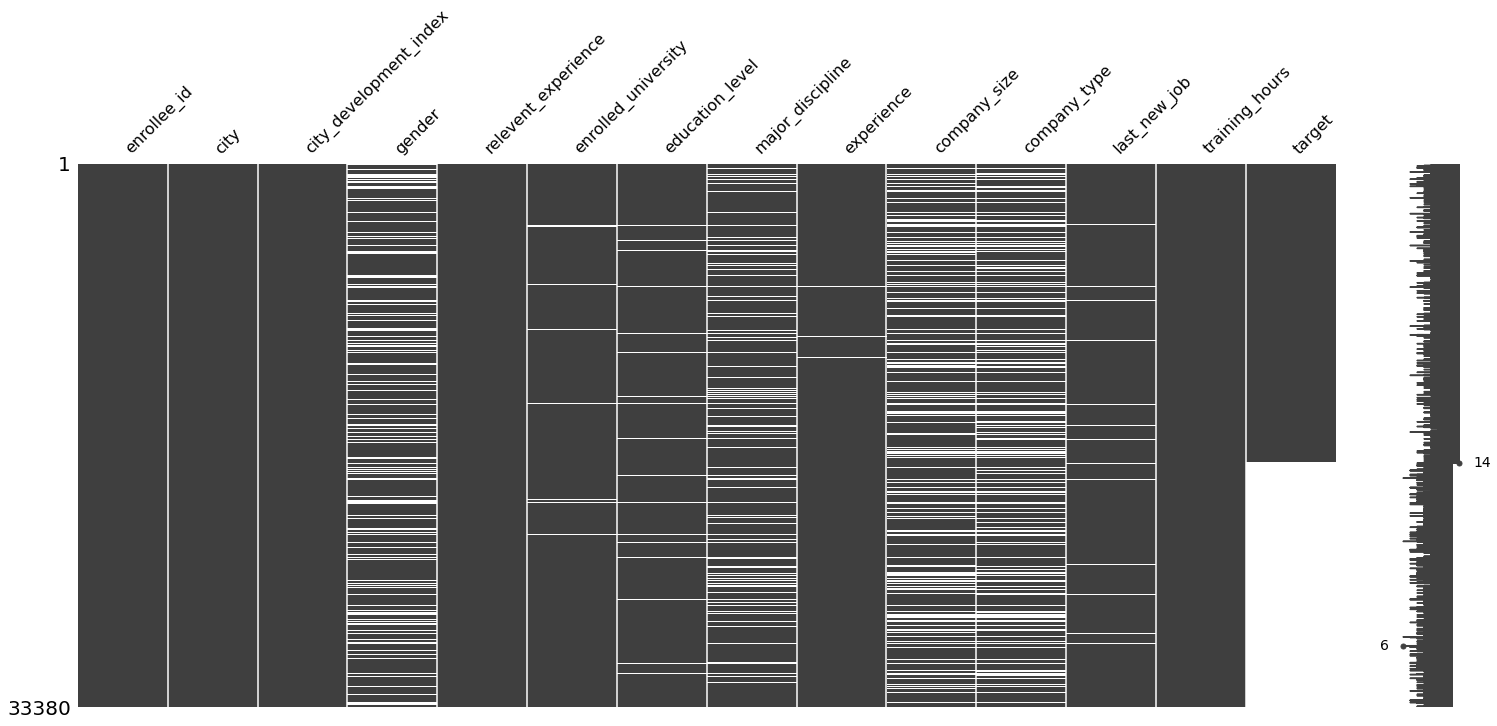

In [214]:
missingno.matrix(combine)

In [215]:
combine.isnull().sum()

enrollee_id               0    
city                      0    
city_development_index    0    
gender                    7486 
relevent_experience       0    
enrolled_university       621  
education_level           852  
major_discipline          5231 
experience                103  
company_size              8830 
company_type              9369 
last_new_job              671  
training_hours            0    
target                    15021
dtype: int64

### Gender

In [216]:
combine["gender"].fillna("Unknown", inplace=True)
combine["gender"].value_counts()

Male       23462
Unknown    7486 
Female     2085 
Other      347  
Name: gender, dtype: int64

### Enrolled University

In [217]:
combine["enrolled_university"].fillna("Unknown", inplace=True)
combine["enrolled_university"] = combine["enrolled_university"].replace("no_enrollment", "No")
combine["enrolled_university"] = combine["enrolled_university"].replace("Full time course", "Full_Time")
combine["enrolled_university"] = combine["enrolled_university"].replace("Part time course", "Part_Time")
combine["enrolled_university"].value_counts()

No           24887
Full_Time    5752 
Part_Time    2120 
Unknown      621  
Name: enrolled_university, dtype: int64

### Education Level

For education level, we can set it to be ordinal value with missing as 0

In [218]:
combine["education_level"].value_counts()

Graduate          19512
Masters           7797 
High School       3708 
Phd               881  
Primary School    630  
Name: education_level, dtype: int64

In [219]:
combine["education_level"].fillna("0", inplace=True)
combine["education_level"] = combine["education_level"].replace("Primary School", "1")
combine["education_level"] = combine["education_level"].replace("High School", "2")
combine["education_level"] = combine["education_level"].replace("Graduate", "3")
combine["education_level"] = combine["education_level"].replace("Masters", "4")
combine["education_level"] = combine["education_level"].replace("Phd", "5")
combine["education_level"].value_counts()

3    19512
4    7797 
2    3708 
5    881  
0    852  
1    630  
Name: education_level, dtype: int64

### Major Discipline

In [220]:
combine["major_discipline"].value_counts()

STEM               24855
Humanities         1212 
Other              678  
Business Degree    585  
Arts               432  
No Major           387  
Name: major_discipline, dtype: int64

In [221]:
combine["major_discipline"].fillna("Unknown", inplace=True)
combine["major_discipline"] = combine["major_discipline"].replace("Business Degree", "Business_Degree")
combine["major_discipline"] = combine["major_discipline"].replace("No Major", "No_Major")
combine["major_discipline"].value_counts()

STEM               24855
Unknown            5231 
Humanities         1212 
Other              678  
Business_Degree    585  
Arts               432  
No_Major           387  
Name: major_discipline, dtype: int64

### Experience

We will re-categorise it by binning 

In [222]:
combine["experience"].value_counts()

>20    6150
5      2400
4      2240
3      2166
6      2039
7      1779
2      1756
10     1753
9      1722
8      1423
15     1244
11     1190
14     1080
16     964 
12     905 
1      818 
<1     782 
13     763 
17     659 
19     590 
18     533 
20     321 
Name: experience, dtype: int64

In [223]:
combine["experience"] = combine["experience"].astype("object")

In [224]:
combine["experience"].fillna("-1", inplace=True)
combine["experience"] = combine["experience"].replace(">20", "21")
combine["experience"] = combine["experience"].replace("<1", "0")
combine["experience"] = combine["experience"].astype("int")
combine["experience"].value_counts()

 21    6150
 5     2400
 4     2240
 3     2166
 6     2039
 7     1779
 2     1756
 10    1753
 9     1722
 8     1423
 15    1244
 11    1190
 14    1080
 16    964 
 12    905 
 1     818 
 0     782 
 13    763 
 17    659 
 19    590 
 18    533 
 20    321 
-1     103 
Name: experience, dtype: int64

In [225]:
bins = [-1,0,3,6,9,12,15,18,21]
labels = ["Unknown", "Exp_Tier1", "Exp_Tier2", "Exp_Tier3", "Exp_Tier4", "Exp_Tier5", "Exp_Tier6", "Exp_Tier7"]
combine["experience"] = pd.cut(combine["experience"], bins=bins, labels=labels, right=False)
combine["experience"].value_counts()

Exp_Tier2    6806
Exp_Tier3    5241
Exp_Tier4    4665
Exp_Tier1    3356
Exp_Tier6    2867
Exp_Tier5    2748
Exp_Tier7    1444
Unknown      103 
Name: experience, dtype: int64

### Company Type

In [226]:
combine["company_type"].value_counts()

Pvt Ltd                18114
Funded Startup         1880 
Public Sector          1792 
Early Stage Startup    1029 
NGO                    973  
Other                  223  
Name: company_type, dtype: int64

In [227]:
combine["company_type"].fillna("Unknown", inplace=True)
combine["company_type"] = combine["company_type"].replace("Pvt Ltd", "Pvt_Ltd")
combine["company_type"] = combine["company_type"].replace("Funded Startup", "Funded_Startup")
combine["company_type"] = combine["company_type"].replace("Public Sector", "Public_Sector")
combine["company_type"] = combine["company_type"].replace("Early Stage Startup", "Early_Stage_Startup")
combine["company_type"].value_counts()

Pvt_Ltd                18114
Unknown                9369 
Funded_Startup         1880 
Public_Sector          1792 
Early_Stage_Startup    1029 
NGO                    973  
Other                  223  
Name: company_type, dtype: int64

### Company Size

In [228]:
combine["company_size"].fillna("Unknown", inplace=True)
combine["company_size"] = combine["company_size"].replace("<10", "Size_Tier1")
combine["company_size"] = combine["company_size"].replace("10/49", "Size_Tier2")
combine["company_size"] = combine["company_size"].replace("50-99", "Size_Tier3")
combine["company_size"] = combine["company_size"].replace("100-500", "Size_Tier4")
combine["company_size"] = combine["company_size"].replace("500-999", "Size_Tier5")
combine["company_size"] = combine["company_size"].replace("1000-4999", "Size_Tier6")
combine["company_size"] = combine["company_size"].replace("5000-9999", "Size_Tier7")
combine["company_size"] = combine["company_size"].replace("10000+", "Size_Tier8")
combine["company_size"].value_counts()

Unknown       8830
Size_Tier3    5697
Size_Tier4    4845
Size_Tier8    3666
Size_Tier2    2664
Size_Tier6    2513
Size_Tier1    2464
Size_Tier5    1639
Size_Tier7    1062
Name: company_size, dtype: int64

### Last New Job

In [229]:
combine["last_new_job"].value_counts()

1        13813
>4       6023 
2        5133 
never    3943 
3        1922 
4        1875 
Name: last_new_job, dtype: int64

In [230]:
combine["last_new_job"].fillna("-1", inplace=True)
combine["last_new_job"] = combine["last_new_job"].replace(">4", "5")
combine["last_new_job"] = combine["last_new_job"].replace("never", "0")
combine["last_new_job"] = combine["last_new_job"].astype("int")
combine["last_new_job"].value_counts()

 1    13813
 5    6023 
 2    5133 
 0    3943 
 3    1922 
 4    1875 
-1    671  
Name: last_new_job, dtype: int64

## 3.2 Transformation

We will try to transform the following continuous features closer to a normal distribution (gaussian distribution). Datasets with Gaussian distributions makes applicable to a variety of methods that fall under parametric statistics. Furthermore, conclusions and summaries derived from such analysis are more interpretable with basic statistics knowledge

### Training Hours

In [231]:
combine["training_hours"].describe()

count    33380.000000
mean     65.565638   
std      60.363572   
min      1.000000    
25%      23.000000   
50%      47.000000   
75%      89.000000   
max      336.000000  
Name: training_hours, dtype: float64

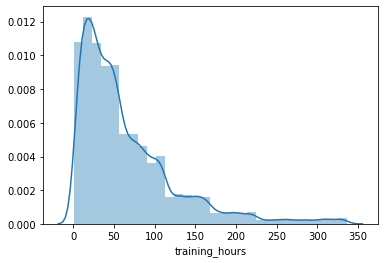

In [232]:
sns.distplot(combine["training_hours"], kde=True, bins=30)

In [233]:
combine["training_hours"] = np.log(combine["training_hours"])
combine["training_hours"].describe()

count    33380.000000
mean     3.759840    
std      0.995878    
min      0.000000    
25%      3.135494    
50%      3.850148    
75%      4.488636    
max      5.817111    
Name: training_hours, dtype: float64

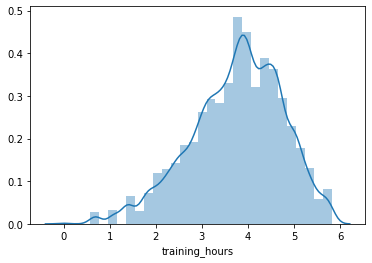

In [234]:
sns.distplot(combine["training_hours"], kde=True, bins=30)

In [235]:
stats.shapiro(combine["training_hours"])

C:\Users\joann\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.



(0.9839884042739868, 0.0)

### City Development Index

In [236]:
combine["city_development_index"].describe()

count    33380.000000
mean     0.846934    
std      0.109972    
min      0.448000    
25%      0.794000    
50%      0.910000    
75%      0.920000    
max      0.949000    
Name: city_development_index, dtype: float64

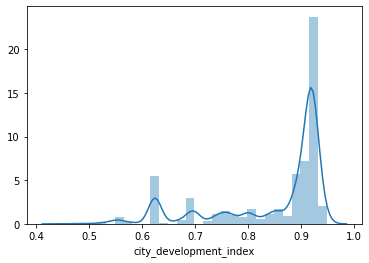

In [237]:
sns.distplot(combine["city_development_index"], kde=True, bins=30)

## 3.3 Encode

In [238]:
encoder = LabelEncoder()
combine["city"] = encoder.fit_transform(combine["city"])

In [239]:
combine.dtypes

enrollee_id               int64   
city                      int32   
city_development_index    float64 
gender                    object  
relevent_experience       object  
enrolled_university       object  
education_level           object  
major_discipline          object  
experience                category
company_size              object  
company_type              object  
last_new_job              int32   
training_hours            float64 
target                    float64 
dtype: object

In [240]:
combine["education_level"] = combine["education_level"].astype("int")

In [241]:
combine.dtypes

enrollee_id               int64   
city                      int32   
city_development_index    float64 
gender                    object  
relevent_experience       object  
enrolled_university       object  
education_level           int32   
major_discipline          object  
experience                category
company_size              object  
company_type              object  
last_new_job              int32   
training_hours            float64 
target                    float64 
dtype: object

## 3.4 Separate into Train and Test Set

Split it back to the original train and test set. We create the train_clean for our EDA stage later.

In [242]:
# for EDA later
train_clean = combine[combine["target"].isnull()!= True].drop(["enrollee_id"], axis=1)

In [243]:
train_clean.head()

city  city_development_index   gender      relevent_experience  \
0  41    0.689                   Male     Has relevent experience   
1  112   0.923                   Male     Has relevent experience   
2  48    0.910                   Unknown  Has relevent experience   
3  93    0.666                   Male     Has relevent experience   
4  2     0.887                   Unknown  No relevent experience    

  enrolled_university  education_level major_discipline experience  \
0  No                  3                STEM             Exp_Tier2   
1  No                  3                STEM             Exp_Tier5   
2  No                  3                STEM             Exp_Tier3   
3  No                  3                STEM             Exp_Tier5   
4  No                  4                STEM             Exp_Tier3   

  company_size    company_type  last_new_job  training_hours  target  
0  Size_Tier4   Pvt_Ltd         1             4.663439        0.0     
1  Size_Tier1   Funded_Startup  1             4.234107        0.0     
2  Size_Tier3   Public_Sector   2             1.386294        0.0     
3  Size_Tier3   Pvt_Ltd         1             3.258097        0.0     
4  Unknown      Unknown         2             4.477337        1.0

In [244]:
combine = pd.get_dummies(combine)
combine.shape

(33380, 48)

In [245]:
combine.head()

enrollee_id  city  city_development_index  education_level  last_new_job  \
0  23798        41    0.689                   3                1              
1  29166        112   0.923                   3                1              
2  46           48    0.910                   3                2              
3  18527        93    0.666                   3                1              
4  21751        2     0.887                   4                2              

   training_hours  target  gender_Female  gender_Male  gender_Other  \
0  4.663439        0.0     0              1            0              
1  4.234107        0.0     0              1            0              
2  1.386294        0.0     0              0            0              
3  3.258097        0.0     0              1            0              
4  4.477337        1.0     0              0            0              

   gender_Unknown  relevent_experience_Has relevent experience  \
0  0               1                                             
1  0               1                                             
2  1               1                                             
3  0               1                                             
4  1               0                                             

   relevent_experience_No relevent experience  enrolled_university_Full_Time  \
0  0                                           0                               
1  0                                           0                               
2  0                                           0                               
3  0                                           0                               
4  1                                           0                               

   enrolled_university_No  enrolled_university_Part_Time  \
0  1                       0                               
1  1                       0                               
2  1                       0                               
3  1                       0                               
4  1                       0                               

   enrolled_university_Unknown  major_discipline_Arts  \
0  0                            0                       
1  0                            0                       
2  0                            0                       
3  0                            0                       
4  0                            0                       

   major_discipline_Business_Degree  major_discipline_Humanities  \
0  0                                 0                             
1  0                                 0                             
2  0                                 0                             
3  0                                 0                             
4  0                                 0                             

   major_discipline_No_Major  major_discipline_Other  major_discipline_STEM  \
0  0                          0                       1                       
1  0                          0                       1                       
2  0                          0                       1                       
3  0                          0                       1                       
4  0                          0                       1                       

   major_discipline_Unknown  experience_Unknown  experience_Exp_Tier1  \
0  0                         0                   0                      
1  0                         0                   0                      
2  0                         0                   0                      
3  0                         0                   0                      
4  0                         0                   0                      

   experience_Exp_Tier2  experience_Exp_Tier3  experience_Exp_Tier4  \
0  1                     0                     0                      
1  0                     0                     0      

In [246]:
# Train test split
X = combine[combine["target"].isnull()!=True].drop(["enrollee_id", "target"], axis=1)
y = combine[combine["target"].isnull()!=True]["target"]

X_test = combine[combine["target"].isnull()==True].drop(['enrollee_id', 'target'], axis=1)

X.shape, y.shape, X_test.shape

((18359, 46), (18359,), (15021, 46))

# 4. Exploratory Data Analysis

Let's see how the education level, the enrolled university and the major discipine of the enrollee would affect the target variable

In [247]:
fig = px.parallel_categories(train_clean[["education_level", "enrolled_university", "major_discipline", "target"]],
                             color = "target",
                             color_continuous_scale = px.colors.sequential.Inferno)
fig.show()

Let's see how gender affects the target variable.

In [248]:
fig = px.parallel_categories(train_clean[["gender", "target"]],
                             color = "target",
                             color_continuous_scale = px.colors.sequential.Inferno)
fig.show()

### Relevant Experience

In [249]:
Rel_Exp = pd.crosstab(train_clean["relevent_experience"], train_clean["target"]).reset_index().melt(id_vars="relevent_experience")
fig = px.bar(Rel_Exp, x="relevent_experience", y="value", color="target", barmode="group", height=400, width=900)
fig.show()

### Experience

In [250]:
Exp = pd.crosstab(train_clean["experience"], train_clean["target"]).reset_index().melt(id_vars="experience")
fig = px.bar(Exp, x="experience", y="value", color="target", barmode="group", height=400, width=900)
fig.show()
#plt.figure(figsize=(10,5))
#sns.countplot(x="experience", data=train_clean, order=train_clean["experience"].value_counts().index)

### Company Size

In [255]:
Com_Size = pd.crosstab(train_clean["company_size"], train_clean["target"]).reset_index().melt(id_vars="company_size")
fig = px.bar(Com_Size, x="company_size", y="value", color="target", barmode="group", height=400, width=900)
fig.show()

### Company Type

In [256]:
Com_Type = pd.crosstab(train_clean["company_type"], train_clean["target"]).reset_index().melt(id_vars="company_type")
fig = px.bar(Com_Type, x="company_type", y="value", color="target", barmode="group", height=400, width=900)
fig.show()

### Gender

In [257]:
Gender = pd.crosstab(train_clean["gender"], train_clean["target"]).reset_index().melt(id_vars="gender")
fig = px.bar(Gender, x="gender", y="value", color="target", barmode="group", height=400, width=900)
fig.show()

### Last New Job

In [258]:
LastNewJob = pd.crosstab(train_clean["last_new_job"], train_clean["target"]).reset_index().melt(id_vars="last_new_job")
fig = px.bar(LastNewJob, x="last_new_job", y="value", color="target", barmode="group", height=400, width=900)
fig.show()

### Major Discipline

In [259]:
Major_Dis = pd.crosstab(train_clean["major_discipline"], train_clean["target"]).reset_index().melt(id_vars="major_discipline")
fig = px.bar(Major_Dis, x="major_discipline", y="value", color="target", barmode="group", height=400, width=900)
fig.show()

### Education Level

In [260]:
Education_Level = pd.crosstab(train_clean["education_level"], train_clean["target"]).reset_index().melt(id_vars="education_level")
fig = px.bar(Education_Level, x="education_level", y="value", color="target", barmode="group", height=400, width=900)
fig.show()

# 5. Train Test Split

In [262]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=101)

# 6. Model Building

## Light GBM

In [264]:
model = LGBMClassifier(max_depth=5,
                       learning_rate=0.4,
                       n_estimators=100)

model.fit(X_train, y_train, 
          eval_set = [(X_train, y_train), (X_val, y_val.values)],
          eval_metric="auc",
          early_stopping_rounds=100,
          verbose=200)

pred_y = model.predict_proba(X_val)[:,1]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.897103	training's binary_logloss: 0.263583	valid_1's auc: 0.604872	valid_1's binary_logloss: 0.412572


In [271]:
print(roc_auc_score(y_val, pred_y))
confusion_matrix(y_val, pred_y>0.5)

0.6048721450490155


array([[3118,   66],
       [ 462,   26]], dtype=int64)

In [272]:
fpr, tpr, thresholds = roc_curve(y_val, pred_y)
fig = px.line(x=fpr, y=tpr, width=400, height=400, labels={"x":"False Positive Rates", "y": "True Positive Rates"})
fig.show()

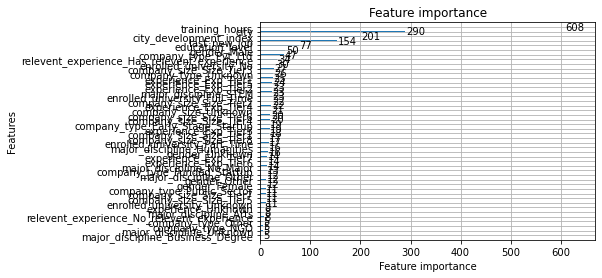

In [275]:
lightgbm.plot_importance(model)

In [278]:
err = []
y_pred_tot_lgm = []

fold = StratifiedKFold(n_splits=15)
i = 1
for train_index, test_index in fold.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = LGBMClassifier(boosting_type = "gbdt",
                       max_depth=5,
                       learning_rate=0.05,
                       n_estimators=5000,
                       min_child_weight=0.01,
                       colsample_bytree=0.5,
                       random_state=101)
    
    m.fit(X_train, y_train, 
          eval_set = [(X_train, y_train), (X_val, y_val)],
          early_stopping_rounds=200,
          eval_metric="auc",
          verbose=200)
    
    pred_y = m.predict_proba(X_val)[:,1]
    print("err_lgm: ", roc_auc_score(y_val, pred_y))
    err.append(roc_auc_score(y_val, pred_y))
    pred_test = m.predict_proba(X_test)[:,1]
    i = i + 1
    y_pred_tot_lgm.append(pred_test)

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.778308	training's binary_logloss: 0.33601	valid_1's auc: 0.693262	valid_1's binary_logloss: 0.360569
Early stopping, best iteration is:
[44]	training's auc: 0.716278	training's binary_logloss: 0.358247	valid_1's auc: 0.697507	valid_1's binary_logloss: 0.361885
err_lgm:  0.697507347656638
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.782801	training's binary_logloss: 0.333853	valid_1's auc: 0.663603	valid_1's binary_logloss: 0.370079
Early stopping, best iteration is:
[44]	training's auc: 0.719788	training's binary_logloss: 0.357495	valid_1's auc: 0.673016	valid_1's binary_logloss: 0.36909
err_lgm:  0.6730161327077357
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.778607	training's binary_logloss: 0.335612	valid_1's auc: 0.677431	valid_1's binary_logloss: 0.367209
Early stopping, best iteration is:
[82]	training's auc: 0.738

In [279]:
np.mean(err,0)

0.670387252047497

## XGBoost

In [283]:
errxgb = []
y_pred_tot_xgb = []

fold = StratifiedKFold(n_splits=15)
i = 1
for train_index, test_index in fold.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = XGBClassifier(boosting_type="gbdt",
                      max_depth=5,
                      learning_rate=0.07,
                      n_estimators=5000,
                      random_state=101)
    m.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)],
          early_stopping_rounds=200,
          eval_metric="auc",
          verbose=200)
    pred_y = m.predict_proba(X_val)[:,-1]
    print("err_xgb: ", roc_auc_score(y_val, pred_y))
    errxgb.append(roc_auc_score(y_val, pred_y))
    pred_test = m.predict_proba(X_test)[:, -1]
    i = i + 1
    y_pred_tot_xgb.append(pred_test)

[0]	validation_0-auc:0.664322	validation_1-auc:0.669101
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-auc:0.799414	validation_1-auc:0.692853
Stopping. Best iteration:
[74]	validation_0-auc:0.741934	validation_1-auc:0.703155

err_xgb:  0.703154671824147
[0]	validation_0-auc:0.667902	validation_1-auc:0.637911
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-auc:0.806905	validation_1-auc:0.642743
Stopping. Best iteration:
[37]	validation_0-auc:0.711603	validation_1-auc:0.664249

err_xgb:  0.6642486108108424
[0]	validation_0-auc:0.664761	validation_1-auc:0.670337
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_

In [284]:
np.mean(errxgb, 0)

0.6695833023135076

## CatBoost

In [288]:
errCB = []
y_pred_tot_cb = []

fold = StratifiedKFold(n_splits=15)
i = 1
for train_index, test_index in fold.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = CatBoostClassifier(n_estimators=5000,
                           random_state=101,
                           eval_metric="AUC",
                           learning_rate=0.03, 
                           max_depth=5)
    m.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)],
          early_stopping_rounds=200,
          verbose=200)
    pred_y = m.predict_proba(X_val)[:,-1]
    print("err_cb: ", roc_auc_score(y_val, pred_y))
    errCB.append(roc_auc_score(y_val, pred_y))
    pred_test = m.predict_proba(X_test)[:, -1]
    i = i + 1
    y_pred_tot_cb.append(pred_test)

0:	test: 0.5763085	test1: 0.5952887	best: 0.5952887 (0)	total: 155ms	remaining: 12m 52s
200:	test: 0.7024720	test1: 0.6954652	best: 0.6957164 (198)	total: 4.55s	remaining: 1m 48s
400:	test: 0.7365635	test1: 0.7006246	best: 0.7015507 (371)	total: 8.83s	remaining: 1m 41s
600:	test: 0.7622960	test1: 0.7003149	best: 0.7018225 (559)	total: 13.2s	remaining: 1m 36s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7018224526
bestIteration = 559

Shrink model to first 560 iterations.
err_cb:  0.7018224525689043
0:	test: 0.5796964	test1: 0.5465546	best: 0.5465546 (0)	total: 21.1ms	remaining: 1m 45s
200:	test: 0.7021177	test1: 0.6651601	best: 0.6662586 (185)	total: 4.13s	remaining: 1m 38s
400:	test: 0.7375275	test1: 0.6637169	best: 0.6671117 (286)	total: 8.14s	remaining: 1m 33s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6671117136
bestIteration = 286

Shrink model to first 287 iterations.
err_cb:  0.6671117135962324
0:	test: 0.5767404	test1: 0.5901059

In [289]:
np.mean(errCB, 0)

0.6667544787068121

In [292]:
(np.mean(err, 0) + np.mean(errxgb, 0) + np.mean(errCB, 0))/3

0.6689083443559389

## Stacking the predictions

Taking the average of the these 3 classifiers

In [295]:
submission = pd.DataFrame()
submission["enrollee_id"] = combine[combine["target"].isnull()==True]["enrollee_id"]
submission["target"] = (np.mean(y_pred_tot_lgm, 0) + np.mean(y_pred_tot_cb, 0) + np.mean(y_pred_tot_xgb))/3
submission.to_csv("Stacking.csv", index=False, header=True)
submission.head()

enrollee_id    target
0  16548        0.410734
1  12036        0.129281
2  11061        0.275503
3  5032         0.133779
4  17599        0.136821

## Neural Networks with 2 Layers

In [301]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if(logs.get("val_AUC") > 0.68):
            self.model.stop_training =True
            
callbacks = myCallback()

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Input(shape=(X.shape[1],)),
                                    tf.keras.layers.Dense(100, activation="relu"),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.summary()

model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["AUC"])

history = model.fit(
                     X_train,
                     y_train,
                     epochs = 30,
                     validation_data = (X_val, y_val),
                     callbacks = [callbacks])

score = model.evaluate(X_val, y_val, verbose=1)

print("Test Score:", score[0])
print("Test AUC:", score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               4700      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 5,721
Trainable params: 5,721
Non-trainable params: 0
_________________________________________________________________
Train on 17136 samples, validate on 1223 samples
Epoch 1/30
17136/17136 [==============================] - 4s 242us/sample - loss: 0.4012 - AUC: 0.5620 - val_loss: 0.4019 - val_AUC: 0.5416
Epoch 2/30
17136/17136 [==============================] - 2s 113us/sample - loss: 0.3846 - AUC: 0.6127 - val_loss: 0.4037 - val_AUC: 0.6204
Epoch 3/30
17136/17136 [=============================

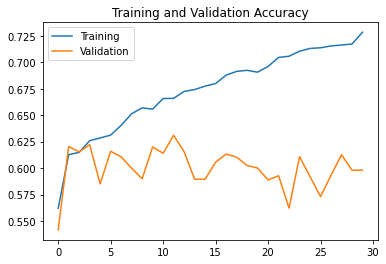

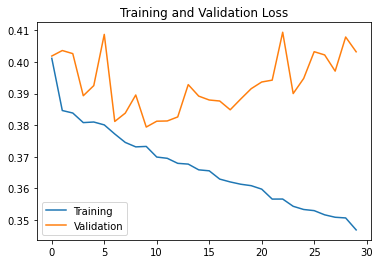

In [302]:
auc = history.history["AUC"]
val_auc = history.history["val_AUC"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(auc))

plt.plot(epochs, auc, label="Training")
plt.plot(epochs, val_auc, label="Validation")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

plt.plot(epochs, loss, label="Training")
plt.plot(epochs, val_loss, label="Validation")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [303]:
pred_test = model.predict(X_test)
submission = pd.DataFrame()
submission["enrollee_id"] = combine[combine["target"].isnull()==True]["enrollee_id"]
submission["target"] = pred_test
submission.to_csv("NN.csv", index=False, header=True)
submission.head()

enrollee_id    target
0  16548        0.301039
1  12036        0.058337
2  11061        0.318499
3  5032         0.026343
4  17599        0.078362

In [304]:
submission.shape

(15021, 2)